# ANALYSIS SUMMARY:
-------------

For any deep learning problem, it is important to have more and more data. Our analysis, infact shows that this is true. Additionally, other stuffs like Exponential weighted average Batch normalization makes the model more robust.

* First, we implement a simple base line model where we simple get embeddings for each image in the train and cv set. Note, we use the weights from the pretrained inception model from Face Net. The embeddings(features) were trained using a SVM classifier and the cross validation set was tested. The avg validation accuracy for 10 Fold was appx 35%, which is not a very great number.

* Due to bad outcomes from the base line model, we try to finetune the last layer of inception net with 90 images (30 image each label) and without exp weighted batch normalization. The accuracy of the model was very poor, jumping between 10% to 60%.

* Then we added more data 180 images (+30 images each label) the model performed little better than the previous model. But still the outcomes were inconsistent.

* Adding Exponential batch norm , made the results consistent accross runs. But we still had accuracy droping to 10%-20% per batch.

* We added more data 300 images (100 images per label). The results were far batter than the previous run and were also consistent. The results at this point were consistent. Cross validation 1 batch accuracy was between 60 to 70 percent. The problem however was that the accuracy decreased after epoch 6. Early stopping could help.

* After adding learning rate decay, as expected the cross validation accuracy gets more consistent accross different batches and produces a accuracy of 83% at epoch 10.

#### Shrewd finding:
In the code we have many different seeds. The output highly depends on the seed we use, because the triplet selection may find many hard negatives, and selecting one based on seed may be biased.
  * When we run the code from start we see that at batch 10 a lot of images are miscalssified. The common pattern is that they are all similar type of images. For example, sam (I) have two different segment of image, 1) with long hairs, 2) With trimmed hair. When we run the model and observe the misclassification images, we see that all the images misclassified were trimmed hair images.

2. We try different values of triplet_selection_alpha (threshold for negative images to qualify as hard negative). We observe better confidence (probability) outcomes of the prediction when triplet_selection_alpha is greater. For example **pred_prob(alpha=0.7) > pred_prob(alpha=0.5) > pred_prob(alpha=0.3) > pred_prob(alpha=0.1)**. If an image is classified as sam then the ** pred_prob(alpha=0.7) = 0.98, pred_prob(alpha=0.5) = 0.8, pred_prob(alpha=0.3) = 0.7, pred_prob(alpha=0.1) = 0.4**

3. **ACCURACY:**
   * At triplet_selection_alpha=0.09, we saw accuracy of 0.9 consistent accross many epoch, for 1st fold
   * At triplet_selection_alpha=0.07, we saw accuracy of 0.86(avg) consistent accross many epoch, for 1st fold
   * At triplet_selection_alpha=0.2, we saw accuracy decreasing to 0.8 consistency accross many epoch, for 1st fold. When compared to 0.09, the triplet selction alpha value of 0.2 seems to overfit a little bit, hence the confidence of prediction (pred_prob) decreases.
   * When we run all the 10 folds, the accuracy performance of each model (alpha 0.09, 0.07, 0.05, 0.03) all provides a avg accuracy of 78% accross all Folds. The reason for this is that few folds such as Fold 2, 3, 7 perform very poor. 
   * The above situation is inevitable, since we only select 1 hard negative that too using a random seed. A good way to be sure of it would be to randomly select 2 hard-negatives for each anchor and positive pair instead of 1. This might slow down the run, but at the same time this may help convergence very fast, could be in 5 epochs. Other thing is to check differnt learning rates.
   
4. PROPER INITIALIZATION OF WEIGHTS REALLY MATTERS, We see difference in outcomes (accuracy) when we use different seeds.
   For example, A difference (dramatic differnce) in accuracy form 66% to 75% and 80% to 86%

#### 17 Jan: The average cross validation accuracy was good enough (83%). The problem however was that when is tested a image (Raj and Sam), Raj image was classified as Soham with 60% accuracy. This is strange (the reason could be because Raj had two very different type of images, one with long beard and one with no beard at all). Raj also had some bad pictures. However so the model should have learned. Why not is the question? 
##### TO do's : 
     * try removing beard pictures and see, if the model is performing good. 
     * crop only the face from the image, not the frame containing the face and shoulders 
#### The below statistics were observed when we dont induce random brightness and random contrast. So we are actually passing good images as input, we expect the system to learn fast.
 * When we reduce triplet_selection_alpha = 0.00001 and keep learning rate = 0.00009, then the model doesnt learn much of the stuff, rather it thinks it has learned and doesn't produce any triplets. Fails even in 7 epochs. Also produces very bad probabilities.
 * Learning rate 0.00001 is very slow, a good learning rate in seen to be 0.0001. Triplet selection was found good to be at triplet_selection_alpha = 0.005 -> 0.01. If we go triplet_selection_alpha < 0.003, the model does not produce hard negative triplets, hence the learning is not very great.
 * triplet_loss_penalty: 0.4 seemed to high, loss decreased immediately and output propabilities were okay, correct predictions were at the range of 0.60 to 0.85 and bad predictions were 0.39, 0.45. No triplets that met the triplet selection criteria were found after 8 epochs.
 * Even after making triplet_loss_penalty: 0.2, the model performed as equivallent to tht model behaviour at triplet_loss_penalty: 0.4 and No triplets that met the triplet selection criteria were found after 8 epochs.
 

#### 20 Jan:
When we use Xavier initialization the weights (distribution) of the last two layers are very close to uniform in nature. When we use truncated normal weights then the distributions are normal with high variance. Xavier initializzation learns very fast when compared to truncated normal. With truncated normal the model overfits a lot. Adding Dropout to the last layer before the embeddings bought stability in the cross validation output. An important thing here to observe was that the cross validation accuracy was consistent 0.8 for epoch 2 to epoch 12. But the classification probability increased from epoch 2 to 12. The model as learned more became more confident. Dropout also avoids mugging the training data, which removes the problem of not getting triplets. Now after drop out we get triplets meeting the triplet_selection_penalty even till 12th epoch. Overall, dropout was a awesome implementation for consistency and overall improvement.

#### 21 Jan: Found a big bug in the code. I actually did a lot of preprocessing to the training data to train teh weights. However, when I computed the embeddings, I actually  forgot to run the data with the same prprocessing steps. Because the same preprocessing was not applied to the training data and validation data (while calculating the embeddings) the embeddings calculated were not very precise. Also, not treating the training data (while calculating embeddings) changed the distribution of the data set. After making the correction, the accuray increased by 10%.

#### TO NOTE:

The triplet selection is differnt for every differnt run even after having seed. This could be because small changes in embedding may initiate different triplet seletion. Embedding can be different becasue we have many random preprocessing steps. 

In [1]:
from __future__ import division, print_function, absolute_import

import os
import numpy as np
import tensorflow as tf
import logging
# from data_transformer.data_formatter import DataFormatter
from data_transformer.preprocess import Preprocessing

from data_transformer.data_io import  getPickleFile
# from data_transformer.data_prep import DataIO#, genDistinctStratifiedBatches, genRandomStratifiedBatches
from nn.load_params import layer_name, convShape, getWeights
from train_test.model import trainModel_FT, getEmbeddings, trainEmbeddings, summaryBuilder
from train_test.classifier import SVM
from train_test import analysis
import config
from config import path_dict

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

logging.basicConfig(level=logging.DEBUG, filename="logfile.log", filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")

training = False
verification = False
create_batches = False
base_model_run = False


# tensorboard --logdir=/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/data_models

# ONE TIME RUN: 
------------
#### INPUT :  Folder path with images of several people, ensure the image folders are named with the person name
#### OUTPUT: Dumps a pickle file with three keys, dataX, dataY, labelDict. 
            * dataX: images converted into nd array
            * dataY: for each record of nd array, Labels are numerical (1,2,3,4,5)
            * labelDict: Contains the label corresponding to person name.



In [2]:
if training:
    objDP = DataFormatter(path_dict['parent_path'], 'training')
    objDP.createResizedData()
    dataX, dataY, labelDict, person_name_image_num_info = objDP.imageToArray(get_stats=True)
    
    DataFormatter.dumpPickleFile(dataX, dataY, labelDict,
                                 folderPath=os.path.join(path_dict['data_model_path']),
                                 picklefileName='training_imgarr.pickle')

    DataFormatter.dumpCSVFile(person_name_image_num_info,
                                 folderPath=os.path.join(path_dict['data_model_path']),
                                 csvfileName='person_name_image_num_info.csv')
    
    
if verification:
    objDP = DataFormatter(path_dict['parent_path'], 'verification')
    objDP.createResizedData()
    dataX, dataY, labelDict = objDP.imageToArray()
    DataFormatter.dumpPickleFile(dataX, dataY, labelDict,
                               folderPath=os.path.join(path_dict['data_model_path']),
                               picklefileName='verification_imgarr.pickle')

# CREATE DISTINCT/RANDOM STRATIFIED BATCHES:
----------------
#### INPUT: Image nd array as input  [num_images, imgX, imgY, num_channels]
#### OUTPUT: Outputs a pickle file with shape [num_batches, num_image_per_batch, imgX, imgY, num_channels]

       *  We would wanna do stocastic descent for minibatches and update the parameters perbatch. This module attempts to create stratified batches (each batch would have equal distribution of labels). 
       
       * when genDistinctStratifiedBatches. The images in the batched would be distinct (would not repeat)
       * when genRandomStratifiedBatches. No seed is set for shuffling. So Images in different batches may repeat.

In [3]:
if create_batches:
    trainX, trainY, trainLabelDict = DataIO.getPickleFile(path_dict['data_model_path'],
                                                                 'training_imgarr.pickle')
    verX, verY, verLabelDict = DataIO.getPickleFile(path_dict['data_model_path'],
                                                           'verification_imgarr.pickle')
    print(trainX.shape, trainY.shape)
    print(verX.shape, verY.shape)
    genDistinctStratifiedBatches(trainX, trainY,
                          fileName='distinct_stratified_batches.pickle')

## RESET TENSORFLOW GRAPH

In [4]:
def reset_graph():  # Reset the graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## GET INCEPTION WEIGHTS

In [5]:
moduleWeightDict = getWeights(path_dict['inception_nn4small_weights_path'])

# TRAIN AND TEST
---------

TO DO's:

1. Remove the random weight initialiazer for the last layer, and initialize it 
   with the inception net weights and then finetune.  **DONE**

2. implement a module to save weights as checkpoints to the disk.  **DONE**

3. create a function to toggle between Random weight initializer, Inception net weight initializer 
   and using the saved checkpoint for the last Inception layer. **DONE**
   
4. REMEBER TO STORE THE exponential weighted average of mean and variable in the batch normalization 
      fine tune function. SET THESE AS A VARIABLE (LOOK AT CIFAR CODE FOR HELP) **DONE**
 
5. Add more images. **DONE**

6. Create a complete workflow train the network and perform cross validation: **DONE**

7. Store 1 image encodings for the 3-4 labels you have.

8. For a new image, pass the image throught network, get the encoding and see which is the most closest face using the encoding from the step 6.

9. Try :
    1. SVM classfication on embedding feature space: Get cross validation accuracy: **DONE**
    2. Softmax classification on embedding feature space: Get cross validation accuracy. 
    
10. The triplet selection now has, random selection of Hard negative. Having random selection makes it difficult to adjust parameters. So make is generated by a sedd, but the sees itself should be generated randomly via a different sees. Since having the same seeed decide a triplet would be problematic becasue the same hard negative would always be selected. **DONE**

11. Add learning rate decay. **DONE**

12. Softmax classifier

13. Add baseline model, using only pretrained weights: **DONE**

14. Add Statistics, for example images that werent classified. What was the probability of classification. 
    If the image was classified that what is the confidence. **DONE**
    
15. When we run the code again without restarting the jupyter notebook, then we get a complete different output. This could be the result of some values already persisting in the notebook. CHECK if it is due to the seed or some value persisting. (YUP SEED MATTERS, BECAUSE WHEN WE SET SEED BASED ON THE SEED VALUE TAKEN BY 2ND RUN (THAT PRODUCED GOOD OUTPUT, THE INITIAL CV ACCURACY WERE APPX 90%))

16. condition dropout to only work during train time

# BASELINE MODEL:
---------------

### When using Pretrained weights for all layers
* We see that the training accuracy is pretty high (which would be the case) but the cross validation accuracy every fold is at an average 35% which is very less but better than random guessing. We know that convolutional layer at later stage are able to learn very complex features. The inception net weights were trained on a dataset that is different from the dataset being used here despite both being images of faces. Hence the model would overfit.

* There fore it is suggested to finetune last few layers of the network and relearning the weights fof only last few layers.

In [6]:
from tensorflow.python.framework import ops
import config
from config import myNet
from copy import deepcopy

which_file = 'ext_rsz_distinct_stratified_batches.pickle'
checkpoint_file_name = 'ext_rsz_distinct_stratified_model'

class Execute():
    def __init__(self, params, myNet, embeddingType='finetune'):
        self.params = params
        self.embeddingType = embeddingType
        self.myNet = myNet
        self.myNet['learning_rate'] = 0.0001
        
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        print (preprocessedData.shape, dataIN.shape[0])
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']:dataIN[numImage,:]
            }
            preprocessedData[numImage,:] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                      feed_dict=feed_dict)
        return preprocessedData
        
    def train(self, trnX_, trnY_, sess):
        '''
            1. Preprocess the image and directly get the embedding without finetuning.
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the embeddings.
        '''
        trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.params)
        embeddings = sess.run(trainEmbedGraph['embeddings'], 
                              feed_dict={trainEmbedGraph['inpTensor']:trnX_})
        logging.info('Training Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_, 
                      model_name='baseline_nFold_%s'%(str(self.nFold)))
        train_labels, train_label_prob = obj_svm.classify(embeddings, 
                                model_name='baseline_nFold_%s'%(str(self.nFold)))
        return train_labels, train_label_prob
    
    def cvalid(self, cvX_, sess):
        embedGraph = getEmbeddings(self.myNet['image_shape'], self.params)
        embeddings = sess.run(embedGraph['embeddings'], 
                              feed_dict={embedGraph['inpTensor']:cvX_})
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings, 
                                             model_name='baseline_nFold_%s'%(str(self.nFold)))
        return cv_labels, cv_label_prob
    
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))

    def run(self):
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = getPickleFile(
            folderPath=path_dict['batchFolderPath'], picklefileName=which_file, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in  np.arange(len(dataX))]
        cvBatch_idx = [i for i in  np.arange(len(dataX))]
        logging.info('dataX.shape = %s, dataY.shape = %s',str(dataX.shape), str(dataY.shape))
            
        avg_tr_acc = 0
        avg_cv_acc = 0
        # LOOP FOR N-FOLD CROSS VALIDATION
        for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
            self.nFold = nFold + 1
            logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
            trnX = dataX[trn_batch_idx,:]
            trnY = dataY[trn_batch_idx,:]
            cvX = dataX[cv_batch_idx,:]
            cvY = dataY[cv_batch_idx,:]
            logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s', 
                  str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))
            
            # Reset graph to do a fresh start for each Fold
            reset_graph()
            self.preprocessGraphDict = Preprocessing().preprocessImageGraph(
                                                                imageShape=self.myNet["image_shape"])
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4]) # accumulate all batches
                preprocessedData = self.runPreprocessor(dataIN=trnX_, sess=sess)
                logging.info('Preprocessed Data.shape = %s', str(preprocessedData.shape))
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(preprocessedData, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                avg_tr_acc = avg_tr_acc + tr_acc
                print ("Fold: %s, Train acc = %s "%(str(self.nFold) , str(tr_acc)))

                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, _ = self.cvalid(cvX, sess)
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                avg_cv_acc = avg_cv_acc + cv_acc
                print ("Fold: %s, CV acc = %s "%(str(self.nFold) , str(cv_acc)))
                    
#                     break
        print ("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s "%(str(self.nFold) , 
                                                                       str(round(avg_tr_acc/self.nFold, 3)), 
                                                                       str(round(avg_cv_acc/self.nFold, 3)))
              )
    
# base_model_run = True   
if base_model_run:
    objExec = Execute(params=deepcopy(moduleWeightDict), myNet=myNet, embeddingType='finetune')
    objExec.run()

# FINE TUNE MODEL:
------------

### When Fine tuning the weights of the last two layers
* When we fine tune only the last inception layer of the new and use the same configured SVM classifier, we see that the cross validation accuracy has increased by more that 25%.


In [12]:
def vizualize(validacc_dict, trainacc_dict, meanValidAcc, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None):
    fig1, axs = plt.subplots(rows, columns, figsize=figsize, facecolor='w', edgecolor='k')   # 
#     print (axs)
#     if columns > 1:
    axs = axs.ravel()
    numFolds = len(validacc_dict.keys())
    for foldNum in np.arange(numFolds):
#         print (foldNum)
        axs[foldNum].plot(validacc_dict[foldNum])
        axs[foldNum].plot(trainacc_dict[foldNum])
        axs[foldNum].axhline(y=meanValidAcc, color = 'k')
        axs[foldNum].set_title('Validation/Training accuracy Fold:%s '%str(foldNum))
        axs[foldNum].legend(['validation acc', 'training acc', ['n-fold avg valid acc']], loc=4)

In [8]:
from tensorflow.python.framework import ops
import config
from config import myNet
from train_test.analysis import save_prediction_analysis
from copy import deepcopy

# which_file = 'distinct_stratified_batches.pickle'
# checkpoint_file_name = 'distinct_stratified_model'

'''
dataX = [num_batches, image_per_batch, image_x, image_y, image_channels]
dataY = [num_batches, labels]

'''


class Execute():
    def __init__(self, myNet, embeddingType='finetune', params={}):
        self.myNet = myNet
        self.embeddingType = embeddingType
        
        #         print (hyper_params)
        if 'learning_rate_override' in params.keys():
            self.myNet['learning_rate'] = params['learning_rate_override']
        self.init_finetune_weight = params['init_finetune_weight']
        self.write_tensorboard_summary = params['write_tensorboard_summary']
        self.save_for_analysis = params['save_for_analysis']
        self.use_checkpoint = params['use_checkpoint']
        self.how_many_folds = params['how_many_folds']
        self.numEpochs = params['numEpochs']
        self.which_eopch_to_save = params['which_eopch_to_save']
        self.checkpoint_file_name = params['checkpoint_file_name']
        self.batch_file_name = params['batch_file_name']
    
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']: dataIN[numImage, :]
            }
            preprocessedData[numImage, :] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                     feed_dict=feed_dict)
        return preprocessedData
    
    def resetWeights(self, weightsIN):
        logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
        self.weights = weightsIN
    
    def setNewWeights(self, sess):
        logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
#         print (tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES))
        if self.embeddingType == 'finetune':
            for learned_vars in config.finetune_variables:
                scope, name = learned_vars.split(':')[0].split('/')
                if len(self.weights[scope][name]) != 0:
                    var_ = sess.run(learned_vars)
                    logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
                                 str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
                    self.weights[scope][name] = var_
                else:
                    raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
                        str(scope), str(name)))
    
    def train(self, trnX_, trnY_, sess):
        '''
            1. Make the use of getEmbedding to get the graph with last layer parameter updated with the
            fine tuned weights.
            2. Get the new embedding for batch/epoch using the computation graph
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the new embeddings.
        '''
        logging.info('Fetch Embeddings for Train: Performing SVM classification on the preprocessed train data')
        # CREATE THE EMBEDDING GRAPH WITH LATEST WEIGHTS
        embeddingGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        trnX_pp = self.runPreprocessor(dataIN=trnX_, sess=sess)
        feed_dict = {embeddingGraph['inpTensor']: trnX_pp}
        embeddings = sess.run(embeddingGraph['embeddings'], feed_dict=feed_dict)
        
        logging.info('Training Embeddings shape %s', embeddings.shape)
        
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_, model_name='final_model_Fold_%s' % (str(self.nFold)))
        train_labels, train_label_prob = obj_svm.classify(embeddings, model_name='final_model_Fold_%s' % (str(
                self.nFold)))
        return train_labels, train_label_prob
    
    
    def cvalid(self, cvX_, sess):
        logging.info('Fetch Embeddings for CV: Performing SVM classification on the preprocessed Validation data')

        # CREATE THE EMBEDDING GRAPH WITH LATEST WEIGHTS
        embeddingGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        cvX_pp = self.runPreprocessor(dataIN=cvX_, sess=sess)
        feed_dict = {embeddingGraph['inpTensor']: cvX_pp}
        embeddings = sess.run(embeddingGraph['embeddings'], feed_dict=feed_dict)
        
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings, model_name='final_model_Fold_%s' % (str(self.nFold)))
        return cv_labels, cv_label_prob
    
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))
    
    def sess_exec(self, trnX, trnY, cvX, cvY):
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            # Retrieve the checkpoint from previous run: 
            checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
            if len(checkpoints) > 0 and self.use_checkpoint:
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.restore(sess, checkpoint_path)
            
            # Get the summary output for tensorboard
            if self.write_tensorboard_summary:
                self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])
            
            tr_acc_arr = []
            cv_acc_arr = []
            for epoch in np.arange(self.numEpochs):
                self.epoch = epoch + 1
                logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
                # Below loop will minimize the triplet loss and update the parameters
                for batchNum, batchX in enumerate(trnX[0:len(trnX), :]):
                    logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
                    
                    # Step1 : Preprocess the Data
                    preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
                    
                    # Since we improve on our previous prediction, there can be cases where the network has learned a
                    # good enough decision boundary (for a batch) and is unable to find hard negative for the triplet selection. 
                    # In such a case the network would return an empty array, which would raise a run time exception during the 
                    # graph is computed. For such cases we should except an exception, and let the graph proceed. 
                    
                    feed_dict = {self.trn_embed_graph['inpTensor']: preprocessedData}
                    opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
                                                    self.trn_embed_graph['triplet_loss'],
                                                    self.trn_embed_graph['learning_rate']],
                                                   feed_dict=feed_dict)
                    logging.info('Learning Rate (Current) is: %s', str(lr))
                
                # Store the summary, and print the loss, accuracy after every epoch or for every batch
                if self.write_tensorboard_summary:
                    smry = sess.run(self.mergedSummary, feed_dict = feed_dict)
                    self.writer.add_summary(smry, self.epoch)
                
                print("Fold= " + str(self.nFold) +
                      ", Epoch= " + str(self.epoch) +
                      ", Loss= " + "{:.6f}".format(batch_loss))
                
                # Now that we have updated our parameters (weights and biases), we would
                # fetch the embeddings using the updated parameter and train-test model
                # to get an accuracy. Accuracy per epoch is now a good way to go
                self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights
                
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4])  # accumulate all batches
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(trnX_, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                tr_acc_arr.append(tr_acc)
                print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))
                
                
                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, cv_pred_prob = self.cvalid(cvX, sess)
                logging.info('Predicted Labels : %s', str(cv_labels))
                logging.info('Predicted Probabilities : %s', str(cv_pred_prob))
                
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                cv_acc_arr.append(cv_acc)
                print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))
        
                if self.epoch in self.which_eopch_to_save and self.save_for_analysis:
                    logging.info('Saving the output probaboilities for analysis ....')
                    save_prediction_analysis(cv_act=cvY, cv_hat=cv_labels, cv_hat_prob=cv_pred_prob, 
                                             fold=self.nFold, epoch=self.epoch, cvBatch_num = self.cv_batch_idx)
            
            if self.use_checkpoint:
                logging.info('Saving the output probaboilities for analysis ....')
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.save(sess, checkpoint_path)
            
            if self.write_tensorboard_summary:
                self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
                self.writer.close()
        return tr_acc, cv_acc, tr_acc_arr, cv_acc_arr
    
    def run(self, weightsIN):
        self.weights = weightsIN
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = getPickleFile(
                folderPath=path_dict['batchFolderPath'], picklefileName=self.batch_file_name, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
        cvBatch_idx = [i for i in np.arange(len(dataX))]
        
        logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
        
        # NOTE WE HAVE TO RESET THE WEIGHTS to the Inception weights every FOLD
        tr_acc_dict = {}
        cv_acc_dict = {}
        tr_acc_avg = 0
        cv_acc_avg = 0
        for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
            # We reset all the seed indexes to ensure that all the weights/triplet selection for every fold
            # are iniitalized with the save start value for each fold
            config.weight_seed_idx = 0
            config.triplet_seed_idx = 0
            config.preprocess_seed_idx = 0
            #############   MAIN CALL START
            self.nFold = nFold
            self.cv_batch_idx = cv_batch_idx
            print('Training Batch Numbers ', trn_batch_idx) 
            print('CV Batch Number ', self.cv_batch_idx) 
            
            logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
            trnX = dataX[trn_batch_idx, :]
            trnY = dataY[trn_batch_idx, :]
            cvX = dataX[cv_batch_idx, :]
            cvY = dataY[cv_batch_idx, :]
            logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
                         str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))
            
            
            # RESET AND CREATE THE GRAPH
            reset_graph()
            self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type=self.init_finetune_weight)
            self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
            # EXECUTE THE SESSION FOR THE CURRENT FOLD
            tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.sess_exec(trnX, trnY, cvX, cvY)
            self.resetWeights(weightsIN)
            
            ######## add ops to save and restore model
            ########
            ######## add ops to save and restore model    
            
            ###  GET FINAL ACURACY
            tr_acc_avg += tr_acc
            cv_acc_avg += cv_acc
            tr_acc_dict[self.nFold] = tr_acc_arr
            cv_acc_dict[self.nFold] = cv_acc_arr
            print('')
            
            if self.nFold == self.how_many_folds:
                break
            
        cv_acc_avg = round(cv_acc_avg / (self.nFold+1), 3)
        tr_acc_avg = round(tr_acc_avg / (self.nFold+1), 3)
        print("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s " % (str(self.nFold),
                                                                        str(tr_acc_avg),
                                                                        str(cv_acc_avg))
              )
        return tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict

# 10 FOLD LATEST RUN

## triplet_selection_alpha = 0.1, triplet_loss_penalty = 0.1 and learning_rate = 0.0001 (exponential decay)

In [9]:
# Override myNet
myNet['triplet_selection_alpha'] = 0.1
myNet['triplet_loss_penalty'] = 0.1
params =  dict(learning_rate_override = 0.0001,
               init_finetune_weight = 'random', # pretrained
                 write_tensorboard_summary=True,
                 use_checkpoint = False,
                 save_for_analysis = True,
                 how_many_folds = 10,
                 numEpochs = 12,
                 which_eopch_to_save = [5,8,9,10],
                 batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
                 checkpoint_file_name='ext_rsz_distinct_stratified_model')

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 0, Epoch= 1, Loss= 16.356943
Fold: 0, Train acc = 0.888888888889 
Fold: 0, CV acc = 0.766666666667 
Fold= 0, Epoch= 2, Loss= 15.006465
Fold: 0, Train acc = 0.911111111111 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 3, Loss= 14.862300
Fold: 0, Train acc = 0.914814814815 
Fold: 0, CV acc = 0.833333333333 
Fold= 0, Epoch= 4, Loss= 15.199795
Fold: 0, Train acc = 0.92962962963 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 5, Loss= 14.885427
Fold: 0, Train acc = 0.955555555556 
Fold: 0, CV acc = 0.8 
Fold= 0, Epoch= 6, Loss= 13.290457
Fold: 0, Train acc = 0.948148148148 
Fold: 0, CV acc = 0.933333333333 
Fold= 0, Epoch= 7, Loss= 10.613121
Fold: 0, Train acc = 0.962962962963 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 8, Loss= 13.196611
Fold: 0, Train acc = 0.940740740741 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 9, Loss= 8.394834
Fold: 0, Train acc = 0.962962962963 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 10, Loss= 10.250465
Fold: 0, Train acc = 0.97037037037 
Fold: 0, 

Fold: 6, CV acc = 0.833333333333 
Fold= 6, Epoch= 5, Loss= 13.366909
Fold: 6, Train acc = 0.944444444444 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 6, Loss= 12.624484
Fold: 6, Train acc = 0.955555555556 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 7, Loss= 10.393485
Fold: 6, Train acc = 0.962962962963 
Fold: 6, CV acc = 0.8 
Fold= 6, Epoch= 8, Loss= 16.280912
Fold: 6, Train acc = 0.955555555556 
Fold: 6, CV acc = 0.833333333333 
Fold= 6, Epoch= 9, Loss= 9.845867
Fold: 6, Train acc = 0.985185185185 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 10, Loss= 9.298710
Fold: 6, Train acc = 0.985185185185 
Fold: 6, CV acc = 0.9 
Fold= 6, Epoch= 11, Loss= 10.815631
Fold: 6, Train acc = 0.974074074074 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 12, Loss= 7.657005
Fold: 6, Train acc = 0.985185185185 
Fold: 6, CV acc = 0.9 

Training Batch Numbers  [0, 1, 2, 3, 4, 5, 6, 8, 9]
CV Batch Number  7
Fold= 7, Epoch= 1, Loss= 16.594341
Fold: 7, Train acc = 0.885185185185 
Fold: 7

## triplet_selection_alpha = 0.05, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [10]:
# Override myNet
myNet['triplet_selection_alpha'] = 0.05
myNet['triplet_loss_penalty'] = 0.2
params =  dict(learning_rate_override = 0.0001,
               init_finetune_weight = 'random', # pretrained
                 write_tensorboard_summary=True,
                 use_checkpoint = False,
                 save_for_analysis = True,
                 how_many_folds = 10,
                 numEpochs = 12,
                 which_eopch_to_save = [5,8,9,10],
                 batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
                 checkpoint_file_name='ext_rsz_distinct_stratified_model')

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 0, Epoch= 1, Loss= 33.082047
Fold: 0, Train acc = 0.877777777778 
Fold: 0, CV acc = 0.766666666667 
Fold= 0, Epoch= 2, Loss= 30.862326
Fold: 0, Train acc = 0.896296296296 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 3, Loss= 29.910942
Fold: 0, Train acc = 0.9 
Fold: 0, CV acc = 0.833333333333 
Fold= 0, Epoch= 4, Loss= 29.650482
Fold: 0, Train acc = 0.925925925926 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 5, Loss= 29.479527
Fold: 0, Train acc = 0.951851851852 
Fold: 0, CV acc = 0.766666666667 
Fold= 0, Epoch= 6, Loss= 28.634212
Fold: 0, Train acc = 0.944444444444 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 7, Loss= 25.067671
Fold: 0, Train acc = 0.955555555556 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 8, Loss= 30.578344
Fold: 0, Train acc = 0.948148148148 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 9, Loss= 22.549511
Fold: 0, Train acc = 0.962962962963 
Fold: 0, CV acc = 0.933333333333 
Fold= 0, Epoch= 10, Loss= 22.411781
Fold: 0, Train acc = 0.962962962963 
Fold: 0, CV acc = 0.93333333

Fold: 6, Train acc = 0.948148148148 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 6, Loss= 27.924850
Fold: 6, Train acc = 0.962962962963 
Fold: 6, CV acc = 0.9 
Fold= 6, Epoch= 7, Loss= 24.910540
Fold: 6, Train acc = 0.962962962963 
Fold: 6, CV acc = 0.833333333333 
Fold= 6, Epoch= 8, Loss= 31.314049
Fold: 6, Train acc = 0.959259259259 
Fold: 6, CV acc = 0.833333333333 
Fold= 6, Epoch= 9, Loss= 23.357138
Fold: 6, Train acc = 0.977777777778 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 10, Loss= 22.395878
Fold: 6, Train acc = 0.981481481481 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 11, Loss= 25.950279
Fold: 6, Train acc = 0.977777777778 
Fold: 6, CV acc = 0.9 
Fold= 6, Epoch= 12, Loss= 19.537640
Fold: 6, Train acc = 0.988888888889 
Fold: 6, CV acc = 0.9 

Training Batch Numbers  [0, 1, 2, 3, 4, 5, 6, 8, 9]
CV Batch Number  7
Fold= 7, Epoch= 1, Loss= 32.541256
Fold: 7, Train acc = 0.862962962963 
Fold: 7, CV acc = 0.9 
Fold= 7, Epoch= 2, Loss= 31.304426
Fold: 7, Train 

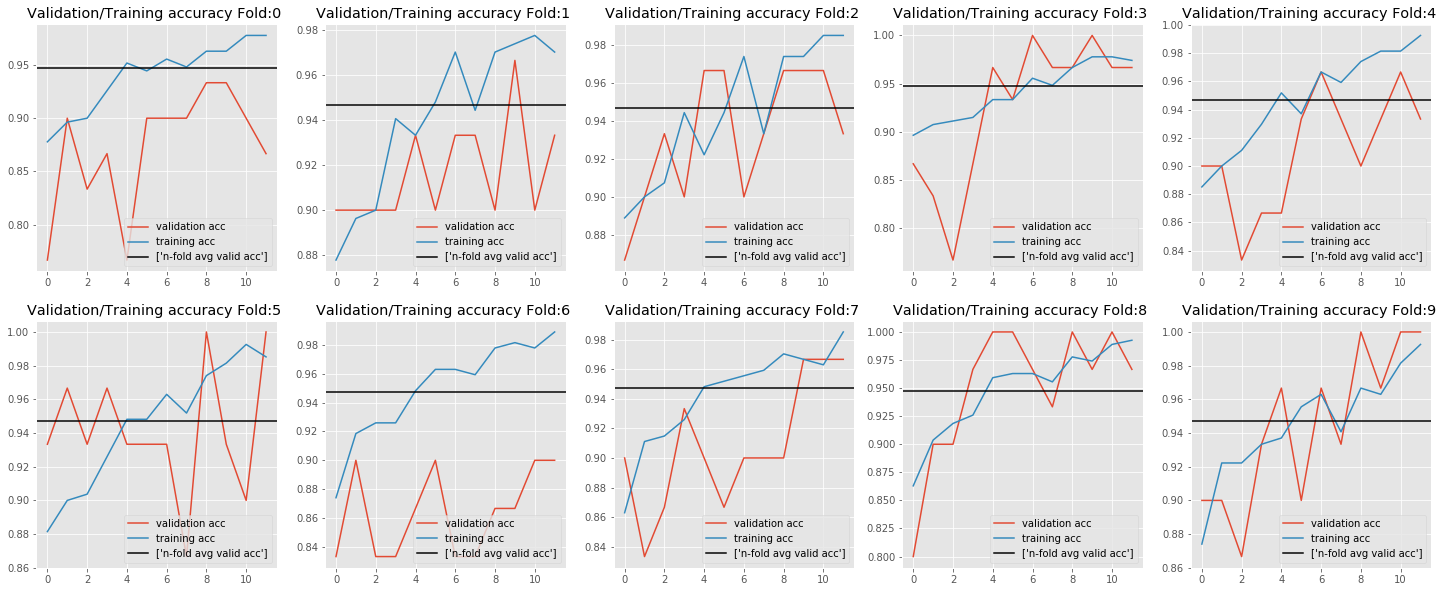

In [13]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

## triplet_selection_alpha = 0.07, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [14]:
# Override myNet
myNet['triplet_selection_alpha'] = 0.07
myNet['triplet_loss_penalty'] = 0.2
params =  dict(learning_rate_override = 0.0001,
               init_finetune_weight = 'random', # pretrained
                 write_tensorboard_summary=True,
                 use_checkpoint = False,
                 save_for_analysis = True,
                 how_many_folds = 10,
                 numEpochs = 12,
                 which_eopch_to_save = [5,8,9,10],
                 batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
                 checkpoint_file_name='ext_rsz_distinct_stratified_model')

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 0, Epoch= 1, Loss= 30.589804
Fold: 0, Train acc = 0.862962962963 
Fold: 0, CV acc = 0.733333333333 
Fold= 0, Epoch= 2, Loss= 31.211569
Fold: 0, Train acc = 0.903703703704 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 3, Loss= 29.055952
Fold: 0, Train acc = 0.911111111111 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 4, Loss= 28.490709
Fold: 0, Train acc = 0.933333333333 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 5, Loss= 28.605476
Fold: 0, Train acc = 0.955555555556 
Fold: 0, CV acc = 0.8 
Fold= 0, Epoch= 6, Loss= 27.117023
Fold: 0, Train acc = 0.940740740741 
Fold: 0, CV acc = 0.933333333333 
Fold= 0, Epoch= 7, Loss= 25.740990
Fold: 0, Train acc = 0.959259259259 
Fold: 0, CV acc = 0.866666666667 
Fold= 0, Epoch= 8, Loss= 30.280884
Fold: 0, Train acc = 0.937037037037 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 9, Loss= 22.182638
Fold: 0, Train acc = 0.959259259259 
Fold: 0, CV acc = 0.9 
Fold= 0, Epoch= 10, Loss= 21.937616
Fold: 0, Train acc = 0.97037037037 
Fold: 0

Fold: 6, Train acc = 0.940740740741 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 6, Loss= 27.208553
Fold: 6, Train acc = 0.955555555556 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 7, Loss= 25.251619
Fold: 6, Train acc = 0.962962962963 
Fold: 6, CV acc = 0.766666666667 
Fold= 6, Epoch= 8, Loss= 30.545694
Fold: 6, Train acc = 0.951851851852 
Fold: 6, CV acc = 0.833333333333 
Fold= 6, Epoch= 9, Loss= 22.546619
Fold: 6, Train acc = 0.974074074074 
Fold: 6, CV acc = 0.866666666667 
Fold= 6, Epoch= 10, Loss= 22.340805
Fold: 6, Train acc = 0.977777777778 
Fold: 6, CV acc = 0.9 
Fold= 6, Epoch= 11, Loss= 24.483065
Fold: 6, Train acc = 0.974074074074 
Fold: 6, CV acc = 0.9 
Fold= 6, Epoch= 12, Loss= 19.462822
Fold: 6, Train acc = 0.988888888889 
Fold: 6, CV acc = 0.9 

Training Batch Numbers  [0, 1, 2, 3, 4, 5, 6, 8, 9]
CV Batch Number  7
Fold= 7, Epoch= 1, Loss= 30.305559
Fold: 7, Train acc = 0.874074074074 
Fold: 7, CV acc = 0.9 
Fold= 7, Epoch= 2, Loss= 30.753445
Fold: 7, Train 

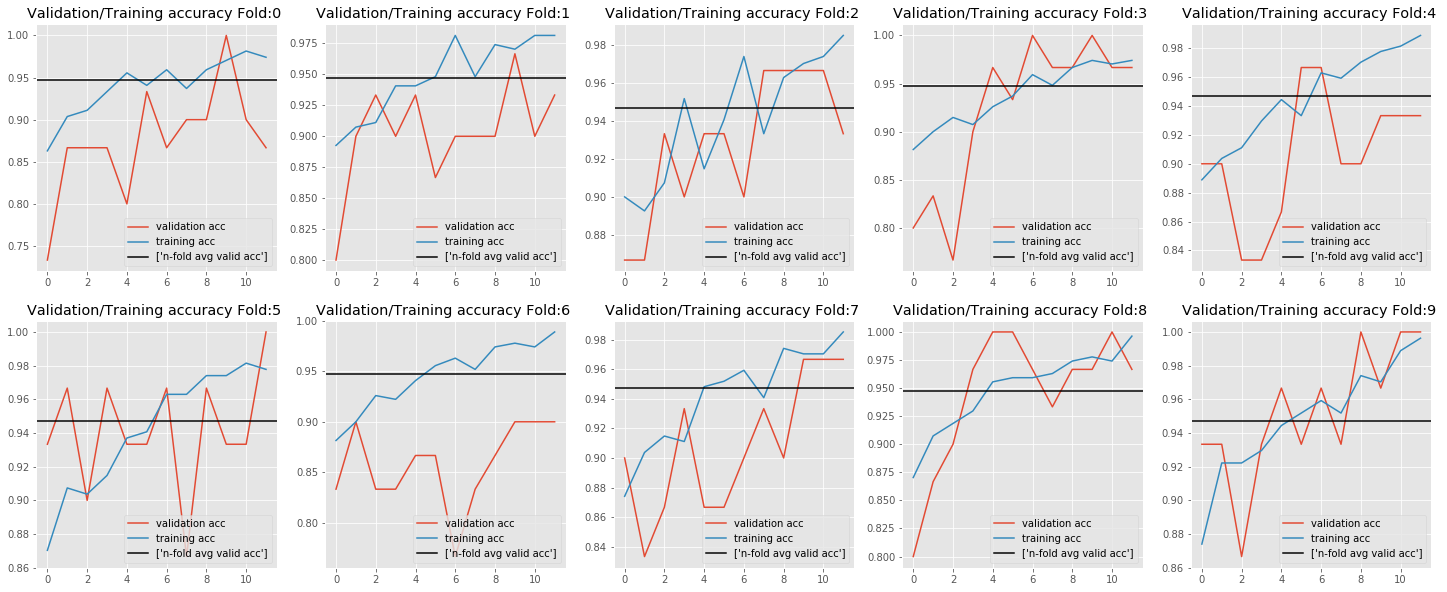

In [15]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

# 10 FOLD RUN
----------------

### OLD MODEL (Not improved version) triplet_selection_alpha = 0.09, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
# Override myNet
myNet['triplet_selection_alpha'] = 0.09
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.465466
Fold: 1, Train acc = 0.818518518519 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 19.508535
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.087723
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 15.677329
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 5, Loss= 13.216620
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 6, Loss= 8.815880
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.303071
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 3.753622
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.028427
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 2.033058
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 

Training

Fold: 8, CV acc = 0.8 
Fold= 8, Epoch= 7, Loss= 10.297041
Fold: 8, Train acc = 0.87037037037 
Fold: 8, CV acc = 0.8 
Fold= 8, Epoch= 8, Loss= 3.946305
Fold: 8, Train acc = 0.866666666667 
Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 9, Loss= 1.752281
Fold: 8, Train acc = 0.859259259259 
Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 10, Loss= 2.491436
Fold: 8, Train acc = 0.855555555556 
Fold: 8, CV acc = 0.8 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 22.718025
Fold: 9, Train acc = 0.833333333333 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 2, Loss= 18.811560
Fold: 9, Train acc = 0.855555555556 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 3, Loss= 18.628277
Fold: 9, Train acc = 0.851851851852 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 4, Loss= 15.991251
Fold: 9, Train acc = 0.859259259259 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 5, Loss= 12.878878
Fold: 9, Train acc = 0.862962962963 
Fold: 9, CV acc = 0.83333333333

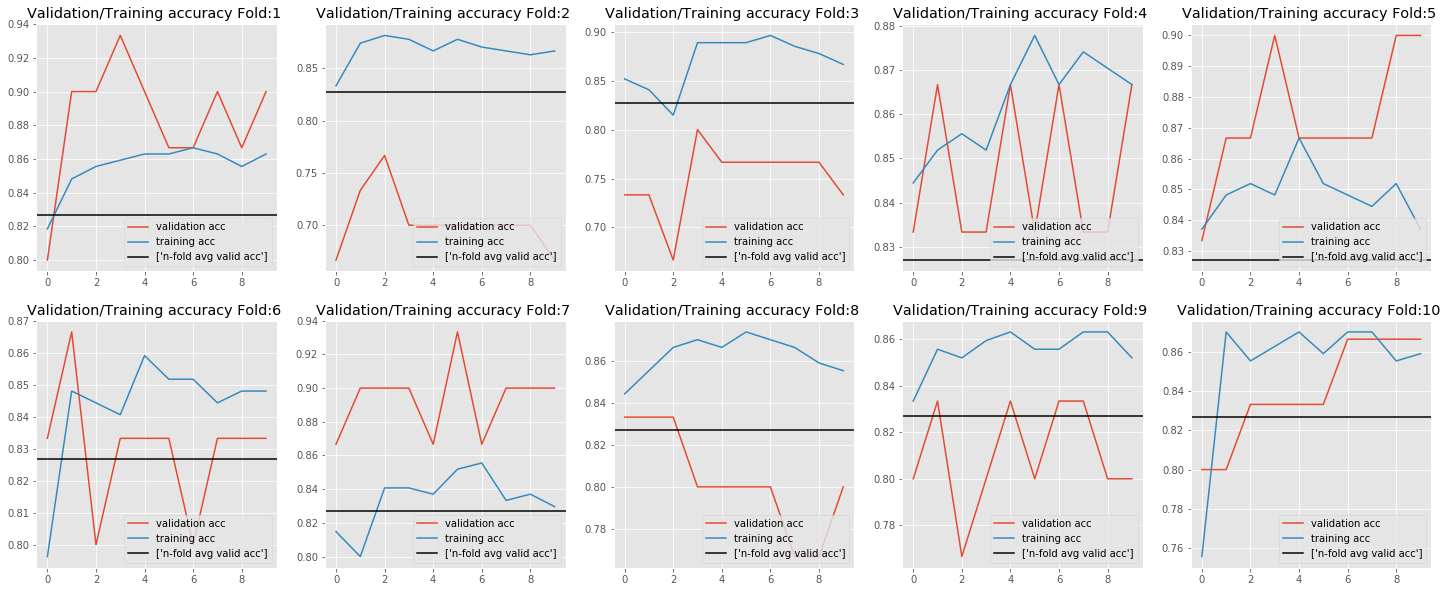

In [10]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.07, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [11]:
myNet['triplet_selection_alpha'] = 0.07
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 23.262985
Fold: 1, Train acc = 0.82962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 18.825903
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.497753
Fold: 1, Train acc = 0.837037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 16.749117
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 14.382219
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 6, Loss= 9.779840
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 7, Loss= 9.818924
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 4.872028
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 2.510174
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 1.995747
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV a

Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 7, Loss= 10.869102
Fold: 8, Train acc = 0.859259259259 
Fold: 8, CV acc = 0.8 
Fold= 8, Epoch= 8, Loss= 4.058407
Fold: 8, Train acc = 0.844444444444 
Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 9, Loss= 2.275113
Fold: 8, Train acc = 0.840740740741 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 10, Loss= 2.108642
Fold: 8, Train acc = 0.844444444444 
Fold: 8, CV acc = 0.833333333333 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 23.175941
Fold: 9, Train acc = 0.848148148148 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 2, Loss= 19.064720
Fold: 9, Train acc = 0.859259259259 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 3, Loss= 18.614382
Fold: 9, Train acc = 0.855555555556 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 4, Loss= 16.580835
Fold: 9, Train acc = 0.855555555556 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 5, Loss= 13.442160
Fold: 9, Train acc = 0.85925925925

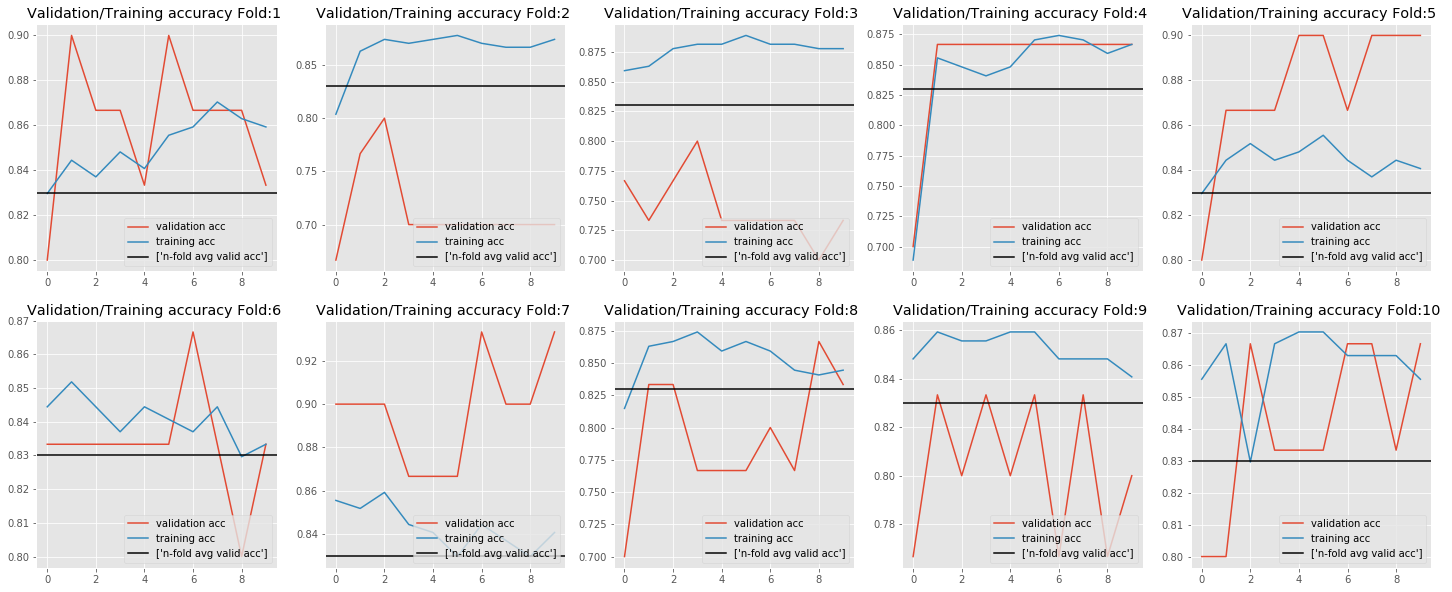

In [12]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.05, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [8]:
myNet['triplet_selection_alpha'] = 0.05
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.709976
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 19.219387
Fold: 1, Train acc = 0.825925925926 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.761038
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 16.246586
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 5, Loss= 15.570947
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 10.135323
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.656178
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 5.991520
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 3.292241
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 3.520585
Fold: 1, Train acc = 0.862962962963 
Fold: 1, C

Fold: 8, CV acc = 0.666666666667 
Fold= 8, Epoch= 7, Loss= 12.004269
Fold: 8, Train acc = 0.862962962963 
Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 8, Loss= 5.181422
Fold: 8, Train acc = 0.859259259259 
Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 9, Loss= 3.254675
Fold: 8, Train acc = 0.859259259259 
Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 10, Loss= 2.599407
Fold: 8, Train acc = 0.859259259259 
Fold: 8, CV acc = 0.833333333333 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 22.968952
Fold: 9, Train acc = 0.866666666667 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 2, Loss= 19.034300
Fold: 9, Train acc = 0.862962962963 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 3, Loss= 19.330154
Fold: 9, Train acc = 0.866666666667 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 4, Loss= 16.878759
Fold: 9, Train acc = 0.822222222222 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 5, Loss= 14.212431
Fold: 9, Train acc = 0.

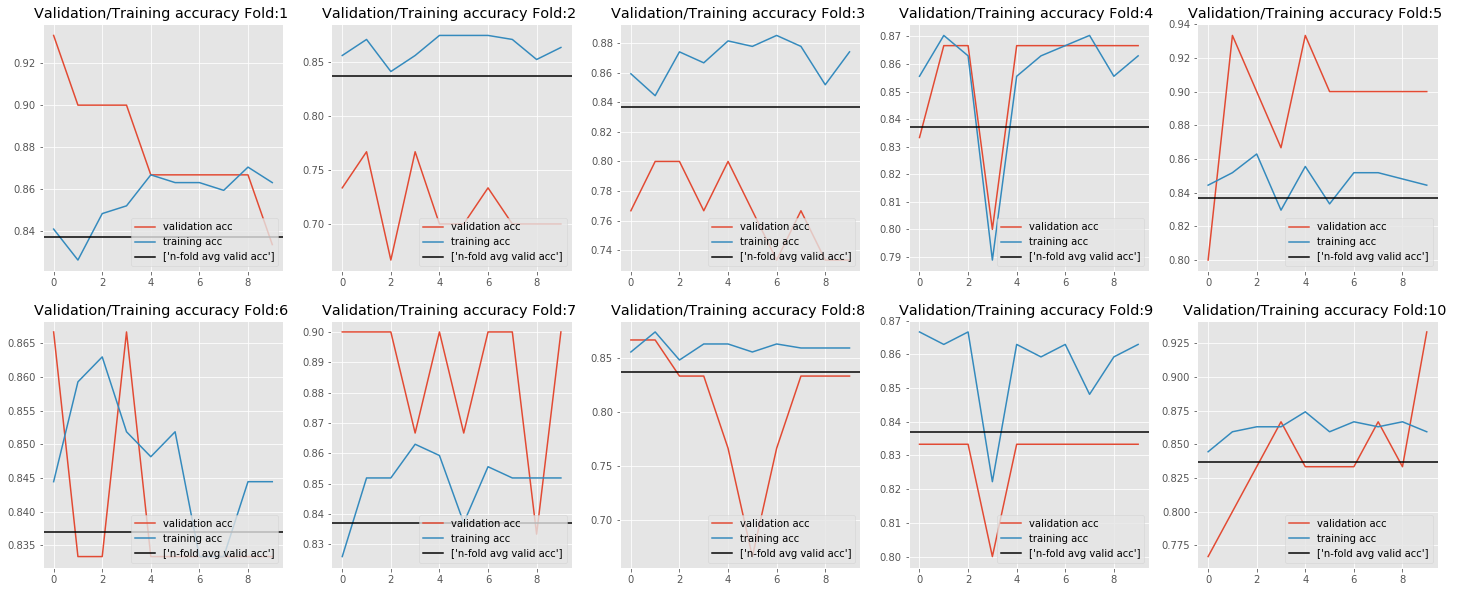

In [9]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.03, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [10]:
myNet['triplet_selection_alpha'] = 0.03
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 23.523905
Fold: 1, Train acc = 0.762962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 19.836103
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 3, Loss= 18.797239
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 17.308893
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 16.597874
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 10.839310
Fold: 1, Train acc = 0.82962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 7, Loss= 10.192699
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 8, Loss= 5.769829
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 9, Loss= 2.994316
Fold: 1, Train acc = 0.822222222222 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 10, Loss= 3.111269
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.8

Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 6, Loss= 8.091993
Fold: 8, Train acc = 0.877777777778 
Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 7, Loss= 11.988955
Fold: 8, Train acc = 0.866666666667 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 8, Loss= 6.008586
Fold: 8, Train acc = 0.87037037037 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 9, Loss= 3.123818
Fold: 8, Train acc = 0.866666666667 
Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 10, Loss= 3.562645
Fold: 8, Train acc = 0.840740740741 
Fold: 8, CV acc = 0.833333333333 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 23.400045
Fold: 9, Train acc = 0.692592592593 
Fold: 9, CV acc = 0.7 
Fold= 9, Epoch= 2, Loss= 19.107574
Fold: 9, Train acc = 0.859259259259 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 3, Loss= 19.029976
Fold: 9, Train acc = 0.862962962963 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 4, Loss= 15.925242
Fold: 9, Train acc = 0.87

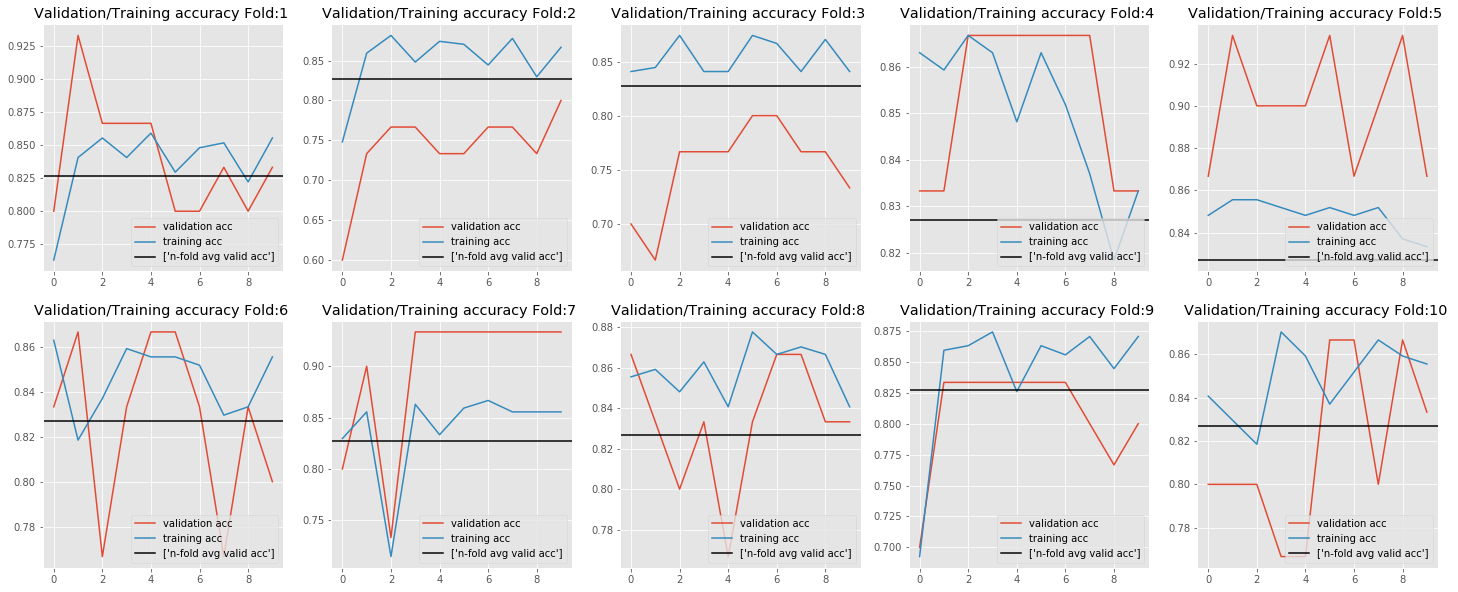

In [11]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

# 1 FOLD RUN
-----------

### triplet_selection_alpha = 0.1, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
# When 
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 21.956341
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 18.601765
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 3, Loss= 18.104637
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 15.094838
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 12.437945
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 8.238983
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 7, Loss= 9.622285
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 8, Loss= 4.144698
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.133195
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 10, Loss= 2.457368
Fold: 1, Train acc = 0.859259259259 


0


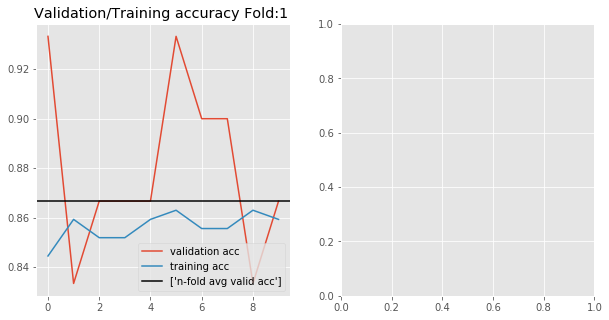

In [10]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.09, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
# When 
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.465466
Fold: 1, Train acc = 0.818518518519 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 19.508535
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.087723
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 15.677329
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 5, Loss= 13.216620
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 6, Loss= 8.815880
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.303071
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 3.753622
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.028427
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 2.033058
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 

Total 1 

0


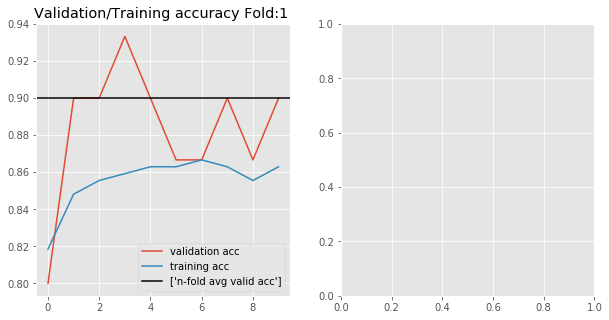

In [10]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.07, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [7]:
# When 'triplet_selection_alpha' = 0.05 and 'triplet_loss_penalty' = 0.2
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.709976
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 19.219387
Fold: 1, Train acc = 0.825925925926 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.761038
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 16.246586
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 5, Loss= 15.570947
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 10.135323
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.656178
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 5.991520
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 3.292241
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 3.520585
Fold: 1, Train acc = 0.862962962963 
Fold: 1, C

In [ ]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.05, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [7]:
# When 'triplet_selection_alpha' = 0.07 and 'triplet_loss_penalty' = 0.2
params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', params=params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 23.262985
Fold: 1, Train acc = 0.82962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 18.825903
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.497753
Fold: 1, Train acc = 0.837037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 16.749117
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 14.382219
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 6, Loss= 9.779840
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 7, Loss= 9.818924
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 4.872028
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 2.510174
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 1.995747
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV a

In [ ]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

## TEST IMAGES

In [67]:
from __future__ import division, print_function, absolute_import

import cv2
import numpy as np
import os
from scipy import  misc

from config import path_dict, myNet

FACE_CASCADE=cv2.CascadeClassifier(path_dict['haar_cascade'])

def resize_image(image, resize_shape):
    if image.shape[0] < resize_shape[0] or image.shape[1] < resize_shape[1]:
        return []
    else:
        imageResized = misc.imresize(image, myNet['image_shape'])
        imageResized = np.array(imageResized)

        return imageResized
    

def detect_extract_faces(image_path, face_extracted_path, face_detection_path, store=True):
    image=cv2.imread(image_path)
    image_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    faces = FACE_CASCADE.detectMultiScale(image_grey,scaleFactor=1.16,
                                          minNeighbors=5,minSize=(25,25),flags=0)
    faces_arr = []
    rect_arr = []
    for num, (x,y,w,h) in enumerate(faces):
        print ('Rectangle dim: ', x,y,w,h)
        sub_img = image[y-10:y+h+10,x-10:x+w+10]
        print(sub_img.shape)
        sub_img = resize_image(sub_img, resize_shape=myNet['image_shape'])
        
        if len(sub_img) > 0:
            print (sub_img.shape)
            face_dump_path = os.path.join(face_extracted_path,
                                          str(os.path.basename(image_path).split('.')[0]) + str(num) + ".jpg")
            print(face_dump_path)
            faces_arr.append(sub_img)
            rect_arr.append([x,y,w,h])
            cv2.imwrite(face_dump_path, sub_img)
            
        # Place rectangles for the regions
        cv2.rectangle(image,(x,y),(x+w,y+h),(255, 255,0),2)
    
    print ('asaasasasasas ', os.path.join(face_detection_path, os.path.basename(image_path)))
    cv2.imwrite(os.path.join(face_detection_path, os.path.basename(image_path)), image)
    return np.array(faces_arr), np.array(rect_arr)

In [68]:

import config
from tensorflow.python.framework import ops
# from face_detection.detect_extract_faces import detect_extract_faces

class Test():
    def __init__(self, myNet, params):
        self.myNet = myNet
        self.checkpoint_file_name = params['checkpoint_file_name']
        self.batch_file_name = params['batch_file_name']
        
        _, _, self.labelDict = getPickleFile(
                folderPath=path_dict['parent_path'], picklefileName='training_imgarr.pickle', getStats=True
        )
        print (self.labelDict)
    
    def resetWeights(self, weightsIN):
        logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
        self.weights = weightsIN
        
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))
    
    def setNewWeights(self, sess):
        logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
        for learned_vars in config.finetune_variables:
            scope, name = learned_vars.split(':')[0].split('/')
            if len(self.weights[scope][name]) != 0:
                var_ = sess.run(learned_vars)
                logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
                             str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
                self.weights[scope][name] = var_
            else:
                raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
                    str(scope), str(name)))
                
    def test(self, input_image_arr):
        self.weights = moduleWeightDict#get_pretrained_weights()
        config.weight_seed_idx = 0
        logging.info('input_image_arr.shape = %s', str(input_image_arr.shape))
        
        # CREATE THE GRAPH: Use the same training procedure to build the graph
        self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type='random')
        self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
        
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            checkpoint_path = os.path.join(path_dict['checkpoint_path'], 
                                           self.checkpoint_file_name + '.ckpt'
                                           if len(self.checkpoint_file_name.split('.')) == 1
                                           else self.checkpoint_file_name)
            
            # First let's load meta graph and restore weights
            # saver = tf.train.import_meta_graph(checkpoint_path)
            saver.restore(sess, checkpoint_path)
            trainableVars = tf.get_collection(ops.GraphKeys.GLOBAL_VARIABLES)
            
            # Set weights
            self.setNewWeights(sess)
            
            # RUN THE GRAPH
            embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
            embeddings = sess.run(embedGraph['embeddings'],
                                  feed_dict={embedGraph['inpTensor']: input_image_arr})
            logging.info('Cross validation Embeddings shape %s', embeddings.shape)
            obj_svm = SVM()
            cv_labels, cv_label_prob = obj_svm.classify(embeddings,
                                                    model_name='final_model')
            print (cv_labels)
            print(" Probabilities acc = %s " %str(cv_label_prob))
        return self.labelDict, cv_labels, cv_label_prob


In [69]:

class PlotLabeledImages():
    def __init__(self,path_dict):
        self.path_dict = path_dict
        
    def draw_rectangle(self, img, x, y, w, h):
        print ('Input image shape: ', img.shape)
        cv2.rectangle(img,(x,y),(x+w,y+h),(255, 255,0),2)
        return img

    def draw_text(self, img, text, x, y):
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), 2)
        return img
    
    def plot(self, img_path, rect_faces, text_labels):
        img=cv2.imread(img_path)
#         img=cv2.cvtColor(img,cv2.COLOR_BGR2RBG)
        print ('afafasfasf ', img.shape)
        for rect,text in zip(rect_faces, text_labels):
            (x, y, w, h) = rect
            img = self.draw_rectangle(img, x, y, w, h)
            img = self.draw_text(img, text, x, y)
        cv2.imwrite(os.path.join(self.path_dict['face_detection_labeled_test_path'], 
                                 os.path.basename(img_path)), img)
        return img

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
def vizualize(imageArray, rows, columns, figsize=(40, 6)):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='y', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    else:
        axs.imshow(imageArray[0].astype(np.uint8))
#     for no, image in enumerate(imageArray):
        

In [71]:
reset_graph()

from config import myNet, path_dict

params = dict(classification_model = 'svm',
              batch_file_name = 'ext_rsz_distinct_stratified_batches.pickle',
              checkpoint_file_name='ext_rsz_distinct_stratified_model')
full_image_path = '/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_snapshot/img2.jpg'
face_extracted_test_path = path_dict['face_extracted_test_path']
face_detection_test_path = path_dict['face_detection_test_path']

test_faces, rect_faces = detect_extract_faces(full_image_path, face_extracted_test_path, face_detection_test_path)
label_dict, cv_labels, cv_label_prob = Test(myNet, params).test(test_faces)
label_names = [label_dict[str(i)].upper() for i in cv_labels]
print(label_names)
img = PlotLabeledImages(path_dict).plot(full_image_path, 
                               rect_faces=rect_faces, 
                               text_labels=label_names)
print (img.shape)
vizualize(imageArray=[img], rows=1, columns=1, figsize=(40, 6))
# draw_text(img, label_text, rect[0], rect[1]-5)


Rectangle dim:  594 138 192 192
(212, 212, 3)
(96, 96, 3)
/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_extracted/img20.jpg
Rectangle dim:  199 238 161 161
(181, 181, 3)
(96, 96, 3)
/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_extracted/img21.jpg
asaasasasasas  /Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_detection/img2.jpg
The shape of input data (X) is:  (180, 96, 96, 3)
The shape of input data (Y) is:  (180, 1)
Unique labels in dataY is:  [0 1 2]
Label dict:  {'2': 'raj', '0': 'sam', '1': 'soham'}
{'2': 'raj', '0': 'sam', '1': 'soham'}


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /Users/sam/All-Program/App-DataSet/DeepFaceRecognition/data_models/saver_checkpoints/ext_rsz_distinct_stratified_model.ckpt
[2 1]
 Probabilities acc = [ 0.37530078  0.46833057] 
['RAJ', 'SOHAM']
afafasfasf  (770, 974, 3)
Input image shape:  (770, 974, 3)
Input image shape:  (770, 974, 3)


KeyError: 'face_detection_labeled_test_path'

In [33]:
from __future__ import division, print_function, absolute_import

import logging
import os

import numpy as np
import tensorflow as tf
from data_transformer.data_io import getPickleFile

import config
import cv2
from config import path_dict
from collections import defaultdict
from data_transformer.preprocess import Preprocessing
from nn.load_params import getWeights
from train_test.classifier import SVM
from data_transformer.detect_extract_faces import detect_extract_faces
from train_test.model import getEmbeddings, trainEmbeddings, summaryBuilder


def get_pretrained_weights():
    moduleWeightDict = getWeights(path_dict['inception_nn4small_weights_path'])
    return moduleWeightDict


class PlotLabeledImages():
    
    def draw_rectangle(self, img, x, y, w, h):
        print('Input image shape: ', img.shape)
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 2)
        return img
    
    def draw_text(self, img, text, x, y):
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), 2)
        return img
    
    def get_save_labeled_image(self, img_path, rect_faces, text_labels):
        img = cv2.imread(img_path)
        #         img=cv2.cvtColor(img,cv2.COLOR_BGR2RBG)
        for rect, text in zip(rect_faces, text_labels):
            (x, y, w, h) = rect
            img = self.draw_rectangle(img, x, y, w, h)
            img = self.draw_text(img, text, x, y)
        cv2.imwrite(os.path.join(path_dict['face_detection_labeled_test_path'],
                                 os.path.basename(img_path)), img)
        return img
    
    
class DeepFaceRecognition():
    '''
    # This module would train the network for the given parameters and store the weights (create checkpoints) in the
    # disk.
    # This module would also provide a training accuracy and cross validation accuracy, given the fold you select. For
    # example if the input which_fold = 1, then the model will only be trained on first 9 batch and would be
    # validated on
    #  the 10th batch.
    # Lately, for testing purpose, the module will pick up the checkpoint and provide the prediction
    '''
    
    def __init__(self, myNet, embeddingType='finetune', params={}):
        self.myNet = myNet
        self.embeddingType = embeddingType
        
        params_keys = params.keys()
        #         print (hyper_params)
        if 'learning_rate_override' in params_keys:
            self.myNet['learning_rate'] = params['learning_rate_override']
            
        if 'init_finetune_weight' in params_keys:
            self.init_finetune_weight = params['init_finetune_weight']
        
        if 'write_tensorboard_summary' in params_keys:
            self.write_tensorboard_summary = params['write_tensorboard_summary']
        
        if 'save_for_analysis' in params_keys:
            self.save_for_analysis = params['save_for_analysis']
        
        if 'use_checkpoint' in params_keys:
            self.use_checkpoint = params['use_checkpoint']
        
        if 'which_fold' in params_keys:
            if params['which_fold'] >= 10:
                raise ValueError ('The which_fold values runs from 0 through 9')
            self.nFold = params['which_fold']
        
        if 'numEpochs' in params_keys:
            self.numEpochs = params['numEpochs']
        
        if 'which_eopch_to_save' in params_keys:
            self.which_eopch_to_save = params['which_eopch_to_save']
        
        if 'checkpoint_file_name' in params_keys:
            self.checkpoint_file_name = params['checkpoint_file_name']
        
        if 'batch_file_name' in params_keys:
            self.batch_file_name = params['batch_file_name']
            
        if 'test_image_path_arr' in params_keys:
            self.test_image_path_arr = test_image_path_arr
        
        _, _, self.labelDict = getPickleFile(
                folderPath=path_dict['parent_path'], picklefileName='training_imgarr.pickle', getStats=True
        )
        
        # Load the Pre-trained weights from disk
#         self.pretrained_weights = get_pretrained_weights()
        

    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))
    
    def resetWeights(self):
        logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
        self.weights = self.pretrained_weights
    
    def setNewWeights(self, sess):
        logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
        #         trainableVars = tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES)
        if self.embeddingType == 'finetune':
            for learned_vars in config.finetune_variables:
                scope, name = learned_vars.split(':')[0].split('/')
                if len(self.weights[scope][name]) != 0:
                    var_ = sess.run(learned_vars)
                    logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
                                 str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
                    self.weights[scope][name] = var_
                else:
                    raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
                        str(scope), str(name)))
    
    def extract_faces(self, test_image_path_arr):
        '''
             test_faces: If the input image has two people then the test_faces would be a list of two nd array where
             each ndarray represent the face of the person
             
             rect_faces: If the input image has two people then the rect_faces would be a list of two array where
             each array represent the coordinate or rather the x,y coordinate and h and w of the extracted faces.
        '''
        test_image_dict = defaultdict(lambda : defaultdict())
        for num, image_path in enumerate(test_image_path_arr):
            image_name = os.path.basename(image_path).split('.')[0]
            print (image_path)
            print(path_dict['face_extracted_test_path'])
            print (path_dict['face_detection_test_path'])
            test_faces, rect_faces = detect_extract_faces(image_path,
                                                          os.path.join(path_dict['face_extracted_test_path'],
                                                                       '%s.jpg'%str(image_name)),
                                                          os.path.join(path_dict['face_detection_test_path'],
                                                                       '%s.jpg' % str(image_name)),
                                                          store=True)
            test_image_dict[image_name]['test_faces'] = test_faces
            test_image_dict[image_name]['rect_faces'] = rect_faces
            test_image_dict[image_name]['image_path'] = image_path
        return test_image_dict


class FaceRecognition(DeepFaceRecognition):

    def _init__(self, myNet, embeddingType='finetune', params={}):
        DeepFaceRecognition.__init__(self, myNet, embeddingType=embeddingType, params=params)
        
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']: dataIN[numImage, :]
            }
            preprocessedData[numImage, :] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                     feed_dict=feed_dict)
        return preprocessedData
    
    def train(self, trnX_, trnY_, sess):
        '''
            1. Make the use of getEmbedding to get the graph with last layer parameter updated with the
            fine tuned weights.
            2. Get the new embedding for batch/epoch using the computation graph
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the new embeddings.
        '''
        trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(trainEmbedGraph['embeddings'],
                              feed_dict={trainEmbedGraph['inpTensor']: trnX_})
        logging.info('Training Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_, model_name='final_model')
        train_labels, train_label_prob = obj_svm.classify(embeddings, model_name='final_model')
        return train_labels, train_label_prob
    
    def cvalid(self, cvX_, sess):
        embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(embedGraph['embeddings'],
                              feed_dict={embedGraph['inpTensor']: cvX_})
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings,
                                                    model_name='final_model')
        return cv_labels, cv_label_prob
    
#     def exec_batches(self, sess):
#         # Below loop will minimize the triplet loss and update the parameters
#         batch_loss = np.inf
#         lr = None
#         feed_dict ={}
#         for batchNum, batchX in enumerate(self.trnX[0:len(self.trnX), :]):
#             logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
        
#             # Step1 : Preprocess the Data
#             preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
            
#             try:
#                 feed_dict = {self.trn_embed_graph['inpTensor']: preprocessedData}
#                 opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
#                                                 self.trn_embed_graph['triplet_loss'],
#                                                 self.trn_embed_graph['learning_rate']],
#                                                feed_dict=feed_dict)
#             except Exception:
#                 logging.info(
#                         'Exception Raised! Check the log file and confirm if the exception is becasue of empty '
#                         'triplet array. If not then debugg it :)')
#                 logging.info("Fold = %s, Epoch = %s, Loss = %s",
#                              str(self.nFold), str(self.epoch), "{:.6f}".format(batch_loss))
#                 # Store the summary, and print the loss, accuracy after every epoch or for every batch
#         if self.write_tensorboard_summary:
#             smry = sess.run(self.mergedSummary, feed_dict=feed_dict)
#             self.writer.add_summary(smry, self.epoch)
            
#         return batch_loss, lr
    
#     def exec_epochs(self, sess):
#         tr_acc = 0
#         cv_acc = 0
#         tr_acc_arr = []
#         cv_acc_arr = []
#         for epoch in np.arange(self.numEpochs):
#             self.epoch = epoch + 1
#             logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
        
#             batch_loss, lrng_rate = self.exec_batches(sess)
            
#             print("Fold= " + str(self.nFold) +
#                   ", Epoch= " + str(self.epoch) +
#                   ", Loss= " + "{:.6f}".format(batch_loss))
        
#             # Now that we have updated our parameters (weights and biases), we would
#             # fetch the embeddings using the updated parameter and train-test model
#             # to get an accuracy. Accuracy per epoch is now a good way to go
#             self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights

#             # TRAIN, GET TRAINING PREDICTION AND ACCURACY
#             trnX_ = self.trnX.reshape(-1, self.trnX.shape[2], self.trnX.shape[3], self.trnX.shape[4])  # accumulate all
#             # batches
#             trnY_ = self.trnY.flatten()
#             train_labels, _ = self.train(trnX_, trnY_, sess)
#             tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
#             tr_acc_arr.append(tr_acc)
#             print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))

#             # GET CROSS VALIDATION PREDICTION AND ACCURACY
#             cv_labels, cv_pred_prob = self.cvalid(self.cvX, sess)
#             logging.info('Predicted Labels : %s', str(cv_labels))
#             logging.info('Predicted Probabilities : %s', str(cv_pred_prob))

#             cv_acc = self.accuracy(y=self.cvY, y_hat=cv_labels)
#             cv_acc_arr.append(cv_acc)
#             print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))

#         return tr_acc, cv_acc, tr_acc_arr,cv_acc_arr


#     def sess_exec(self):
        
#         saver = tf.train.Saver()
        
#         with tf.Session() as sess:
#             sess.run(tf.global_variables_initializer())

#             # RETRIEVE CHECKPOINTS FROM PREVIOUS RUN
#             checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
#             if len(checkpoints) > 0 and self.use_checkpoint:
#                 checkpoint_path = os.path.join(path_dict['checkpoint_path'],
#                                                self.checkpoint_file_name + '.ckpt'
#                                                if len(self.checkpoint_file_name.split('.')) == 1
#                                                else self.checkpoint_file_name)
#                 saver.restore(sess, checkpoint_path)
            
#             # GET THE SUMMARY GRAPH TO WRITE TENSOR BOARD OUTPUT
#             if self.write_tensorboard_summary:
#                 self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])

#             # RUN FOR MULTIPLE EPOCHS
#             tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.exec_epochs(sess)
            
            
#             # WRITE WEIGHTS (CREATE CHECKPOINT) TO A FILE FOR THE TEST DATA TO USE IT
#             if self.use_checkpoint:
#                 logging.info('Saving the output probaboilities for analysis ....')
#                 checkpoint_path = os.path.join(path_dict['checkpoint_path'],
#                                                self.checkpoint_file_name + '.ckpt'
#                                                if len(self.checkpoint_file_name.split('.')) == 1
#                                                else self.checkpoint_file_name)
#                 saver.save(sess, checkpoint_path)

#             if self.write_tensorboard_summary:
#                 self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
#                 self.writer.close()
#         return tr_acc, cv_acc, tr_acc_arr, cv_acc_arr
    
    def sess_exec(self, trnX, trnY, cvX, cvY):
#         trnX =  self.trnX
#         trnY = self.trnY
#         cvX = self.cvX
#         cvY = self.cvY
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            # Retrieve the checkpoint from previous run: 
            checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
            if len(checkpoints) > 0 and self.use_checkpoint:
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.restore(sess, checkpoint_path)
            
            # Get the summary output for tensorboard
            if self.write_tensorboard_summary:
                self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])
            
            tr_acc_arr = []
            cv_acc_arr = []
            for epoch in np.arange(self.numEpochs):
                self.epoch = epoch + 1
                logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
                # Below loop will minimize the triplet loss and update the parameters
                for batchNum, batchX in enumerate(trnX[0:len(trnX), :]):
                    logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
                    
                    # Step1 : Preprocess the Data
                    preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
                    
                    # Since we improve on our previous prediction, there can be cases where the network has learned a
                    #  good enough
                    # decision boundary (for a batch) and is unable to find hard negative for the triplet selection. 
                    # In such a case
                    # the network would return an empty array, which would raise a run time exception during the 
                    # graph is computed.
                    # For such cases we would except an exception, and let the graph proceed. 
                    
#                     try:
                    feed_dict = {self.trn_embed_graph['inpTensor']: preprocessedData}
                    opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
                                                    self.trn_embed_graph['triplet_loss'],
                                                    self.trn_embed_graph['learning_rate']],
                                                   feed_dict=feed_dict)
                    logging.info('Learning Rate (Current) is: %s', str(lr))
                                 
#                     except Exception:
#                         logging.info(
#                                 'Exception Raised! Check the log file and confirm if the exception is becasue of empty '
#                                 'triplet array. If not then debugg it :)')
#                         logging.info("Fold = %s, Epoch = %s, Loss = %s",
#                                      str(self.nFold), str(self.epoch), "{:.6f}".format(batch_loss))
                
                # Store the summary, and print the loss, accuracy after every epoch or for every batch
                if self.write_tensorboard_summary:
                    smry = sess.run(self.mergedSummary, feed_dict = feed_dict)
                    self.writer.add_summary(smry, self.epoch)
                
                print("Fold= " + str(self.nFold) +
                      ", Epoch= " + str(self.epoch) +
                      ", Loss= " + "{:.6f}".format(batch_loss))
                
                # Now that we have updated our parameters (weights and biases), we would
                # fetch the embeddings using the updated parameter and train-test model
                # to get an accuracy. Accuracy per epoch is now a good way to go
                self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights
                
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4])  # accumulate all batches
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(trnX_, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                tr_acc_arr.append(tr_acc)
                print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))
                
                
                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, cv_pred_prob = self.cvalid(cvX, sess)
                logging.info('Predicted Labels : %s', str(cv_labels))
                logging.info('Predicted Probabilities : %s', str(cv_pred_prob))
                
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                cv_acc_arr.append(cv_acc)
                print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))
        
                if self.epoch in self.which_eopch_to_save and self.save_for_analysis:
                    logging.info('Saving the output probaboilities for analysis ....')
                    save_prediction_analysis(cv_act=cvY, cv_hat=cv_labels, cv_hat_prob=cv_pred_prob, 
                                             fold=self.nFold, epoch=self.epoch, cvBatch_num = self.cv_batch_idx)
            
            if self.use_checkpoint:
                logging.info('Saving the output probaboilities for analysis ....')
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.save(sess, checkpoint_path)
            
            if self.write_tensorboard_summary:
                self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
                self.writer.close()
        return tr_acc, cv_acc, tr_acc_arr, cv_acc_arr

    def run(self, weightsIN):
        self.weights = weightsIN
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = getPickleFile(
                folderPath=path_dict['batchFolderPath'], picklefileName=self.batch_file_name, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
        cvBatch_idx = [i for i in np.arange(len(dataX))]
        
        trn_batch_idx = trnBatch_idx[self.nFold]
        cv_batch_idx = cvBatch_idx[self.nFold]

        print('Training Batch Numbers ', trn_batch_idx)
        print('CV Batch Number ', cv_batch_idx)

        logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
        
        # NOTE WE HAVE TO RESET THE WEIGHTS to the Inception weights every FOLD
        tr_acc_avg = 0
        cv_acc_avg = 0
#         for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
            # We reset all the seed indexes to ensure that all the weights/triplet selection for every fold
            # are iniitalized with the save start value for each fold
        config.weight_seed_idx = 0
        config.triplet_seed_idx = 0
        config.preprocess_seed_idx = 0
        
        #############   MAIN CALL START
        self.cv_batch_idx = cv_batch_idx
        print('Training Batch Numbers ', trn_batch_idx) 
        print('CV Batch Number ', self.cv_batch_idx) 

        logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
        trnX = dataX[trn_batch_idx, :]
        trnY = dataY[trn_batch_idx, :]
        cvX = dataX[cv_batch_idx, :]
        cvY = dataY[cv_batch_idx, :]
        logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
                     str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))

        # RESET AND CREATE THE GRAPH
        reset_graph()
        self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type=self.init_finetune_weight)
        self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
        
        # EXECUTE THE SESSION FOR THE CURRENT FOLD
        tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.sess_exec(trnX, trnY, cvX, cvY)
        self.resetWeights(weightsIN)

        ######## add ops to save and restore model
        ########
        ######## add ops to save and restore model    

        ###  GET FINAL ACURACY
        tr_acc_avg += tr_acc
        cv_acc_avg += cv_acc
        
#         tr_acc_dict[self.nFold] = tr_acc_arr
#         cv_acc_dict[self.nFold] = cv_acc_arr
#         print('')

#         if self.nFold == self.how_many_folds:
#             break
            
#         cv_acc_avg = round(cv_acc_avg / (self.nFold+1), 3)
#         tr_acc_avg = round(tr_acc_avg / (self.nFold+1), 3)
#         print("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s " % (str(self.nFold),
#                                                                         str(tr_acc_avg),
#                                                                         str(cv_acc_avg))
#               )
        return tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict
    
    
#     def fit_save(self):
    
#         self.weights = moduleWeightDict#self.pretrained_weights
#         # GET THE BATCH DATA FROM THE DISK
#         dataX, dataY, labelDict = getPickleFile(
#                 folderPath=path_dict['batchFolderPath'], picklefileName=self.batch_file_name, getStats=True
#         )
        
#         trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
#         cvBatch_idx = [i for i in np.arange(len(dataX))]
        
#         trn_batch_idx = trnBatch_idx[self.nFold]
#         cv_batch_idx = cvBatch_idx[self.nFold]
        
#         print ('dataX, dataY shape: ', dataX.shape, dataY.shape)
        
#         logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
#         print('Training Batch Numbers ', trn_batch_idx)
#         print('CV Batch Number ', cv_batch_idx)
        
#         config.weight_seed_idx = 0
#         config.triplet_seed_idx = 0
#         config.preprocess_seed_idx = 0
        
    
#         logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
#         self.trnX = dataX[trn_batch_idx, :]
#         self.trnY = dataY[trn_batch_idx, :]
#         self.cvX = dataX[cv_batch_idx, :]
#         self.cvY = dataY[cv_batch_idx, :]
#         print ('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s'%
#                      (str(self.trnX.shape), str(self.trnY.shape), str(self.cvX.shape), str(self.cvY.shape)))
# #         logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
# #                      str(self.trnX.shape), str(self.trnY.shape), str(self.cvX.shape), str(self.cvY.shape))
    
#         # RESET AND CREATE THE GRAPH
#         self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type=self.init_finetune_weight)
#         self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
        
#         # EXECUTE THE SESSION FOR THE CURRENT FOLD
#         tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.sess_exec()

#         return tr_acc, cv_acc

    def test_exec_sess(self, input_image_arr):
        self.weights = moduleWeightDict
    
        config.weight_seed_idx = 0
        logging.info('Test input_image_arr.shape = %s', str(input_image_arr.shape))
    
        saver = tf.train.Saver()
    
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
        
            checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                           self.checkpoint_file_name + '.ckpt'
                                           if len(self.checkpoint_file_name.split('.')) == 1
                                           else self.checkpoint_file_name)
            # First let's load meta graph and restore weights
            # saver = tf.train.import_meta_graph(checkpoint_path)
            saver.restore(sess, checkpoint_path)
        
            # SET PRE-TRAINED WEIGHTS FROM THE INITIALIZED INCEPTION WEIGHTS AND SET
            # FINE TUNED WEIGHTS FROM THE CHECKPOINT
            self.setNewWeights(sess)
        
            # RUN THE GRAPH
            embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
            embeddings = sess.run(embedGraph['embeddings'],
                                  feed_dict={embedGraph['inpTensor']: input_image_arr})
            logging.info('Test Image Embeddings shape %s', embeddings.shape)
            obj_svm = SVM()
            cv_labels, cv_label_prob = obj_svm.classify(embeddings,
                                                        model_name='final_model')
            print(cv_labels)
            print(" Probabilities acc = %s " % str(cv_label_prob))
    
        label_names = [self.labelDict[str(i)].upper() for i in cv_labels]
        return label_names, cv_label_prob
    
    def predict(self, test_image_path_arr):
        test_image_dict = self.extract_faces(test_image_path_arr)
        labeled_image_arr = []
        for image, img_features in test_image_dict.items():
            face_arr = img_features['test_faces']
            rect_face_arr = img_features['rect_faces']
            print(face_arr.shape, rect_face_arr.shape)

            label_names, cv_label_prob = self.test_exec_sess(face_arr)

            labeled_image_arr.append(PlotLabeledImages().get_save_labeled_image(img_features['image_path'], rect_faces=rect_face_arr, text_labels=label_names))
    
        return labeled_image_arr




In [34]:

debugg = True
reset_graph()
if debugg:
    from config import myNet
    test_image_path_arr = [
        '/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_snapshot/img2.jpg'
    ]
    # myNet['triplet_selection_alpha'] = 0.1
    myNet['triplet_selection_alpha'] = 0.09
    myNet['triplet_loss_penalty'] = 0.1
    params = dict(learning_rate_override=0.0001,
                  init_finetune_weight='random',
                  use_checkpoint=False,
                  write_tensorboard_summary=False,
                  save_for_analysis=False,
                  which_fold=0,  # In actuality
                  numEpochs=12,
                  which_eopch_to_save=[5, 8, 9, 10],
                  batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
                  checkpoint_file_name='ext_rsz_distinct_stratified_model'
                  )
    
    f_recog_obj = FaceRecognition(myNet=myNet, embeddingType='finetune', params=params)
    tr_acc, cv_acc = f_recog_obj.run(moduleWeightDict)
    labeled_image_arr = f_recog_obj.predict(test_image_path_arr)



The shape of input data (X) is:  (180, 96, 96, 3)
The shape of input data (Y) is:  (180, 1)
Unique labels in dataY is:  [0 1 2]
Label dict:  {'1': 'soham', '0': 'sam', '2': 'raj'}
The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 0, Epoch= 1, Loss= 13.032668
Fold: 0, Train acc = 0.711111111111 
Fold: 0, CV acc = 0.733333333333 
Fold= 0, Epoch= 2, Loss= 11.495213
Fold: 0, Train acc = 0.859259259259 


KeyboardInterrupt: 

In [6]:
class FaceRecognition():
    def __init__(self, myNet, embeddingType='finetune', params={}):
        self.myNet = myNet
        self.embeddingType = embeddingType
        
        params_keys = params.keys()
        #         print (hyper_params)
        if 'learning_rate_override' in params_keys:
            self.myNet['learning_rate'] = params['learning_rate_override']
            
        if 'init_finetune_weight' in params_keys:
            self.init_finetune_weight = params['init_finetune_weight']
        
        if 'write_tensorboard_summary' in params_keys:
            self.write_tensorboard_summary = params['write_tensorboard_summary']
        
        if 'save_for_analysis' in params_keys:
            self.save_for_analysis = params['save_for_analysis']
        
        if 'use_checkpoint' in params_keys:
            self.use_checkpoint = params['use_checkpoint']
        
        if 'which_fold' in params_keys:
            if params['which_fold'] >= 10:
                raise ValueError ('The which_fold values runs from 0 through 9')
            self.nFold = params['which_fold']
        
        if 'numEpochs' in params_keys:
            self.numEpochs = params['numEpochs']
        
        if 'which_eopch_to_save' in params_keys:
            self.which_eopch_to_save = params['which_eopch_to_save']
        
        if 'checkpoint_file_name' in params_keys:
            self.checkpoint_file_name = params['checkpoint_file_name']
        
        if 'batch_file_name' in params_keys:
            self.batch_file_name = params['batch_file_name']
            
        if 'test_image_path_arr' in params_keys:
            self.test_image_path_arr = test_image_path_arr
        
        _, _, self.labelDict = getPickleFile(
                folderPath=path_dict['parent_path'], picklefileName='training_imgarr.pickle', getStats=True
        )
        
#         self.myNet = myNet
#         self.embeddingType = embeddingType
        
#         #         print (hyper_params)
#         if 'learning_rate_override' in params.keys():
#             self.myNet['learning_rate'] = params['learning_rate_override']
#         self.init_finetune_weight = params['init_finetune_weight']
#         self.write_tensorboard_summary = params['write_tensorboard_summary']
#         self.save_for_analysis = params['save_for_analysis']
#         self.use_checkpoint = params['use_checkpoint']
#         self.nFold = params['which_fold']
#         self.numEpochs = params['numEpochs']
#         self.which_eopch_to_save = params['which_eopch_to_save']
#         self.checkpoint_file_name = params['checkpoint_file_name']
#         self.batch_file_name = params['batch_file_name']
        
    
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']: dataIN[numImage, :]
            }
            preprocessedData[numImage, :] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                     feed_dict=feed_dict)
        return preprocessedData
    
    def resetWeights(self, weightsIN):
        logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
        self.weights = weightsIN
    
    def setNewWeights(self, sess):
        logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
#         print (tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES))
        if self.embeddingType == 'finetune':
            for learned_vars in config.finetune_variables:
                scope, name = learned_vars.split(':')[0].split('/')
                if len(self.weights[scope][name]) != 0:
                    var_ = sess.run(learned_vars)
                    logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
                                 str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
                    self.weights[scope][name] = var_
                else:
                    raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
                        str(scope), str(name)))
    
    def train(self, trnX_, trnY_, sess):
        '''
            1. Make the use of getEmbedding to get the graph with last layer parameter updated with the 
            fine tuned weights.
            2. Get the new embedding for batch/epoch using the computation graph
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the new embeddings.
        '''
        trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(trainEmbedGraph['embeddings'],
                              feed_dict={trainEmbedGraph['inpTensor']: trnX_})
        logging.info('Training Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_,
                      model_name='nFold_%s_epoch_%s' % (str(self.nFold), str(self.epoch)))
        train_labels, train_label_prob = obj_svm.classify(embeddings,
                                                          model_name='nFold_%s_epoch_%s' % (
                                                              str(self.nFold), str(self.epoch)))
        return train_labels, train_label_prob
    
    def cvalid(self, cvX_, sess):
        embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(embedGraph['embeddings'],
                              feed_dict={embedGraph['inpTensor']: cvX_})
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings,
                                                    model_name='nFold_%s_epoch_%s' % (str(self.nFold), str(self.epoch)))
        return cv_labels, cv_label_prob
    
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))
    
    def sess_exec(self, trnX, trnY, cvX, cvY):
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            # Retrieve the checkpoint from previous run: 
            checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
            if len(checkpoints) > 0 and self.use_checkpoint:
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.restore(sess, checkpoint_path)
            
            # Get the summary output for tensorboard
            if self.write_tensorboard_summary:
                self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])
            
            tr_acc_arr = []
            cv_acc_arr = []
            for epoch in np.arange(self.numEpochs):
                self.epoch = epoch + 1
                logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
                # Below loop will minimize the triplet loss and update the parameters
                for batchNum, batchX in enumerate(trnX[0:len(trnX), :]):
                    logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
                    
                    # Step1 : Preprocess the Data
                    preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
                    feed_dict = {self.trn_embed_graph['inpTensor']: preprocessedData}
                    opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
                                                    self.trn_embed_graph['triplet_loss'],
                                                    self.trn_embed_graph['learning_rate']],
                                                   feed_dict=feed_dict)
                    logging.info('Learning Rate (Current) is: %s', str(lr))

                # Store the summary, and print the loss, accuracy after every epoch or for every batch
                if self.write_tensorboard_summary:
                    smry = sess.run(self.mergedSummary, feed_dict = feed_dict)
                    self.writer.add_summary(smry, self.epoch)
                
                print("Fold= " + str(self.nFold) +
                      ", Epoch= " + str(self.epoch) +
                      ", Loss= " + "{:.6f}".format(batch_loss))
                
                # Now that we have updated our parameters (weights and biases), we would
                # fetch the embeddings using the updated parameter and train-test model
                # to get an accuracy. Accuracy per epoch is now a good way to go
                self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights
                
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4])  # accumulate all batches
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(trnX_, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                tr_acc_arr.append(tr_acc)
                print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))
                
                
                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, cv_pred_prob = self.cvalid(cvX, sess)
                logging.info('Predicted Labels : %s', str(cv_labels))
                logging.info('Predicted Probabilities : %s', str(cv_pred_prob))
                
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                cv_acc_arr.append(cv_acc)
                print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))
        
                if self.epoch in self.which_eopch_to_save and self.save_for_analysis:
                    logging.info('Saving the output probaboilities for analysis ....')
                    save_prediction_analysis(cv_act=cvY, cv_hat=cv_labels, cv_hat_prob=cv_pred_prob, 
                                             fold=self.nFold, epoch=self.epoch, cvBatch_num = self.cv_batch_idx)
            
            if self.use_checkpoint:
                logging.info('Saving the output probaboilities for analysis ....')
                checkpoint_path = os.path.join(path_dict['checkpoint_path'],
                                       self.checkpoint_file_name + '.ckpt'
                                       if len(self.checkpoint_file_name.split('.')) == 1
                                       else self.checkpoint_file_name)
                saver.save(sess, checkpoint_path)
            
            if self.write_tensorboard_summary:
                self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
                self.writer.close()
        return tr_acc, cv_acc, tr_acc_arr, cv_acc_arr
    
    def run(self, weightsIN):
        self.weights = weightsIN
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = getPickleFile(
                folderPath=path_dict['batchFolderPath'], picklefileName=self.batch_file_name, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
        cvBatch_idx = [i for i in np.arange(len(dataX))]
        trn_batch_idx = trnBatch_idx[self.nFold]
        cv_batch_idx = cvBatch_idx[self.nFold]
        print(trn_batch_idx)
        print(cv_batch_idx)
        logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
        
        # NOTE WE HAVE TO RESET THE WEIGHTS to the Inception weights every FOLD
        tr_acc_dict = {}
        cv_acc_dict = {}
        tr_acc_avg = 0
        cv_acc_avg = 0
        # We reset all the seed indexes to ensure that all the weights/triplet selection for every fold
        # are iniitalized with the save start value for each fold
        config.weight_seed_idx = 0
        config.triplet_seed_idx = 0
        config.preprocess_seed_idx = 0
        #############   MAIN CALL START
        self.cv_batch_idx = cv_batch_idx
        print('Training Batch Numbers ', trn_batch_idx) 
        print('CV Batch Number ', self.cv_batch_idx) 

        logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
        trnX = dataX[trn_batch_idx, :]
        trnY = dataY[trn_batch_idx, :]
        cvX = dataX[cv_batch_idx, :]
        cvY = dataY[cv_batch_idx, :]
        logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
                     str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))


        # RESET AND CREATE THE GRAPH
        reset_graph()
        self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type=self.init_finetune_weight)
        self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
        # EXECUTE THE SESSION FOR THE CURRENT FOLD
        tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.sess_exec(trnX, trnY, cvX, cvY)
        self.resetWeights(weightsIN)

        ######## add ops to save and restore model
        ########
        ######## add ops to save and restore model    

        ###  GET FINAL ACURACY
        tr_acc_avg += tr_acc
        cv_acc_avg += cv_acc
        tr_acc_dict[self.nFold] = tr_acc_arr
        cv_acc_dict[self.nFold] = cv_acc_arr
        print('')


            
        cv_acc_avg = round(cv_acc_avg / (self.nFold+1), 3)
        tr_acc_avg = round(tr_acc_avg / (self.nFold+1), 3)
        print("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s " % (str(self.nFold),
                                                                        str(tr_acc_avg),
                                                                        str(cv_acc_avg))
              )
        return tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict

In [8]:

debugg = True
reset_graph()
if debugg:
    from config import myNet
    test_image_path_arr = [
        '/Users/sam/All-Program/App-DataSet/DeepFaceRecognition/output_data_faces/face_snapshot/img2.jpg'
    ]
    # myNet['triplet_selection_alpha'] = 0.1
    myNet['triplet_selection_alpha'] = 0.09
    myNet['triplet_loss_penalty'] = 0.1
    params = dict(learning_rate_override=0.0001,
                  init_finetune_weight='random',
                  use_checkpoint=False,
                  write_tensorboard_summary=True,
                  save_for_analysis=False,
                  which_fold=0,  # In actuality
                  numEpochs=12,
                  which_eopch_to_save=[5, 8, 9, 10],
                  batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
                  checkpoint_file_name='ext_rsz_distinct_stratified_model'
                  )
    
    f_recog_obj = FaceRecognition(myNet=myNet, embeddingType='finetune', params=params)
    tr_acc, cv_acc = f_recog_obj.run()
    labeled_image_arr = f_recog_obj.predict(test_image_path_arr)

# from copy import  deepcopy
# myNet['triplet_selection_alpha'] = 0.09
# myNet['triplet_loss_penalty'] = 0.1
# params =  dict(learning_rate_override = 0.0001,
#                init_finetune_weight = 'random', # pretrained
#                  write_tensorboard_summary=True,
#                  use_checkpoint = False,
#                  save_for_analysis = True,
#                  which_fold = 0,
#                  numEpochs = 12,
#                  which_eopch_to_save = [5,8,9,10],
#                  batch_file_name='ext_rsz_distinct_stratified_batches.pickle',
#                  checkpoint_file_name='ext_rsz_distinct_stratified_model')

# objExec = FaceRecognition(myNet=myNet, embeddingType='finetune', params=params)
# tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))




The shape of input data (X) is:  (180, 96, 96, 3)
The shape of input data (Y) is:  (180, 1)
Unique labels in dataY is:  [0 1 2]
Label dict:  {'1': 'soham', '2': 'raj', '0': 'sam'}
The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
[1, 2, 3, 4, 5, 6, 7, 8, 9]
0
Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 9]
CV Batch Number  0


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 0, Epoch= 1, Loss= 13.032668
Fold: 0, Train acc = 0.874074074074 
Fold: 0, CV acc = 0.833333333333 
Fold= 0, Epoch= 2, Loss= 13.224599
Fold: 0, Train acc = 0.885185185185 
Fold: 0, CV acc = 0.8 
Fold= 0, Epoch= 3, Loss= 11.871889
Fold: 0, Train acc = 0.877777777778 
Fold: 0, CV acc = 0.833333333333 
Fold= 0, Epoch= 4, Loss= 9.064589
Fold: 0, Train acc = 0.811111111111 


KeyboardInterrupt: 